## Recruitment Task
Joanna Broniarek

In [1]:
import pandas as pd
import sqlite3
import numpy as np
import seaborn as sn
import os

In [2]:
def create_connection(db_file):
    """ create a database connection to the SQLite database
        specified by the db_file
    :param db_file: database file
    :return: Connection object or None
    
    Taken from SQLite website.
    """
    conn = None
    try:
        conn = sqlite3.connect(db_file)
    except Error as e:
        print(e)

    return conn

####  1. Load received SQLite file: database.db.

In [3]:
conn = create_connection(db_file=os.path.join(os.getcwd(),"database.db"))

####   2. Create Pandas DataFrame with x, y, z, color_id and color_name for every record.

In [4]:
df = pd.read_sql_query("SELECT DISTINCT x, y, z, color_id, color_name FROM data d JOIN connection c ON d.connection_id==c.id JOIN additional_data ad ON c.name==ad.color_name", conn)
df.head()

,x,y,z,color_id,color_name
0,44.628947,97.81099110033537,569.700453,11,green
1,40.764309,82.0486367746882,653.904064,4,orange
2,25.849509,63.29510234435348,374.171176,4,orange
3,18.973396,50.59596955801666,440.976635,3,yellow
4,44.787622,39.347747208411256,219.388963,0,red


#### 3. Columns  x, y, z should be converted to floating-point format, and color_id to integers.

In [5]:
print(">> Data types before: \n{}".format(df.dtypes))

>> Data types before: 
x             float64
y              object
z             float64
color_id        int64
color_name     object
dtype: object


In [6]:
df['y'] = df['y'].astype('float')
df['color_id'] = df['color_id'].astype('int16')

#### 4. All invalid records should be removed.

In [7]:
df.dropna(inplace=True)
df.drop_duplicates(inplace=True)

#### 5. Change color_name column to color.

In [8]:
df.rename(columns={'color_name':'color'}, inplace=True)

#### 6. List unique color values.

In [9]:
df['color'].unique()

array(['green', 'orange', 'yellow', 'red', 'black', 'blue'], dtype=object)

#### 7. Leave only data with z = 100.

In [10]:
df = df.loc[df.z==100.]
df.head()

,x,y,z,color_id,color
122,-0.850851,-0.441336,100.0,2,blue
209,-0.458458,-0.401101,100.0,2,blue
249,-1.667668,-0.329684,100.0,2,blue
418,0.394394,-0.439959,100.0,2,blue
420,1.703704,-0.316621,100.0,2,blue


#### 8. Remove red points with a distance from average red points’ position above 1 sigma.

In [11]:
# Find average red points' position
df_red = df.loc[df.color =='red'][['x', 'y', 'z']]
avg_red_position = df_red.agg(['mean'])
avg_red_position

,x,y,z
mean,-1.0,0.043467,100.0


In [12]:
# Calculate Euclidean distance from red points to the average point
df_red['x_avg_red_point'] = avg_red_position['x']['mean']
df_red['y_avg_red_point'] = avg_red_position['y']['mean']
df_red['dist_from_avg_red'] = np.sqrt((df_red['x_avg_red_point'] - df_red['x'])**2 + (df_red['y_avg_red_point']- df_red['y'])**2)

In [13]:
# Find sigma and remove red points with a distance above 1 sigma. 
sigma = df_red['dist_from_avg_red'].std()
selected_indexes = df_red.loc[df_red['dist_from_avg_red'] > sigma].index

df.drop(index=selected_indexes, inplace=True)

#### 9. Make sure rows indices are consecutive integers (starting from 0).

In [14]:
df.reset_index(drop=True, inplace=True)

#### 10. Save the remaining points in a HDF5 file with dataset ns1 containing columns: x, y, color.

In [15]:
df.to_hdf('ns1.h5', key='df', mode='w', data_columns=["x", "y", "color"])

#### 11. Plot data from the HDF5 file using scatter plot (with corresponding colors).

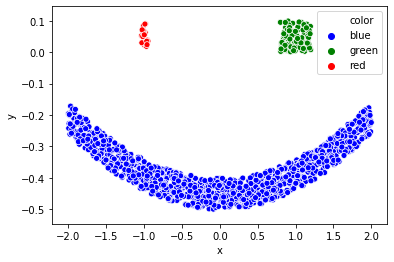

In [16]:
fig=sn.scatterplot(x='x', y='y', hue='color', data=pd.read_hdf('ns1.h5', 'df'), palette=['blue', 'green', 'red'])

#### 12. Add above plot to repository (as separate png file or as notebook cell output).

In [17]:
fig.figure.savefig("/home/jb/Documents/NeuroSys/Smile.png")